In [7]:
import os
from dotenv import load_dotenv
from typing import Literal
from pydantic import BaseModel, Field

from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.messages import convert_to_messages
from langchain.tools.retriever import create_retriever_tool

from langchain_ibm import ChatWatsonx
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams, EmbedTextParamsMetaNames

from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

import trafilatura
import spacy
from langchain.embeddings import LlamaCppEmbeddings
import ibm_db
import ibm_db_dbi

from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_core.documents import Document

from langchain_db2 import db2vs
from langchain_db2.db2vs import DB2VS

In [2]:
load_dotenv(os.getcwd()+"/.env", override=True)
DB_NAME = os.getenv("DB_NAME", "")
DB_HOST = os.getenv("DB_HOST", "")
DB_PORT = os.getenv("DB_PORT", "")
DB_PROTOCOL = os.getenv("DB_PROTOCOL", "")
DB_USER = os.getenv("DB_USER", "")
DB_PASSWORD = os.getenv("DB_PASSWORD", "")

conn_str=f"DATABASE={DB_NAME};hostname={DB_HOST};port={DB_PORT};protocol={DB_PROTOCOL};uid={DB_USER};pwd={DB_PASSWORD}"

try:
    connection = ibm_db_dbi.connect(conn_str, '', '')
    print("Connection successful!")
except Exception as e:
    print("Connection failed!")

Connection successful!


## 1. Load and Preprocess documents

In [3]:
url = 'https://community.ibm.com/community/user/blogs/shaikh-quader/2024/05/07/building-an-in-db-linear-regression-model-with-ibm'
downloaded = trafilatura.fetch_url(url)

if downloaded:
    article = trafilatura.extract(downloaded)
    print(article[:1000])  # Preview first 1000 chars
else:
    print("Failed to fetch content.")

Despite being one of the earlier machine learning techniques, linear regression continues to be a top choice among ML practitioners for a regression task. For the past three years, over 80% of the respondents to Kaggle’s annual state of data science and machine learning survey mentioned linear regression as a ML algorithm they most frequently use. IBM Db2 provides an in-database stored procedure (SP) for Linear Regression as part of its ML library, which is a collection of over 200 SPs for performing different ML tasks in the database. Using the linear regression SP and other functionality of DB2’s ML Library, ML practitioners can build and deploy linear regression models in the database when their ML dataset is available in a Db2 database. In this post, I will show you the following steps of building and using a linear regression pipeline using SQL with a Db2 database:
Let’s begin.
The Regression Task
In this exercise, I will use the GoSales dataset, which is available from this link.

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
def overlapping_sentence_chunker(text, max_words=200, overlap_words=50):
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]
    
    chunks = []
    current_chunk = []
    current_length = 0

    i = 0
    while i < len(sentences):
        sentence = sentences[i]
        sentence_length = len(sentence.split())

        if current_length + sentence_length <= max_words:
            current_chunk.append(sentence)
            current_length += sentence_length
            i += 1
        else:
            chunks.append(" ".join(current_chunk))
            # Start new chunk with overlap
            overlap = []
            overlap_len = 0
            j = len(current_chunk) - 1
            while j >= 0 and overlap_len < overlap_words:
                s = current_chunk[j]
                overlap.insert(0, s)
                overlap_len += len(s.split())
                j -= 1
            current_chunk = overlap
            current_length = overlap_len

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

In [6]:
chunks = overlapping_sentence_chunker(article, max_words=200, overlap_words=50)
print(f"{len(chunks)} chunks created.")
print(chunks[0])

15 chunks created.
Despite being one of the earlier machine learning techniques, linear regression continues to be a top choice among ML practitioners for a regression task. For the past three years, over 80% of the respondents to Kaggle’s annual state of data science and machine learning survey mentioned linear regression as a ML algorithm they most frequently use. IBM Db2 provides an in-database stored procedure (SP) for Linear Regression as part of its ML library, which is a collection of over 200 SPs for performing different ML tasks in the database. Using the linear regression SP and other functionality of DB2’s ML Library, ML practitioners can build and deploy linear regression models in the database when their ML dataset is available in a Db2 database. In this post, I will show you the following steps of building and using a linear regression pipeline using SQL with a Db2 database:
Let’s begin. The Regression Task
In this exercise, I will use the GoSales dataset, which is availa

## 2. Create a retriever tool

In [20]:
embeddings = LlamaCppEmbeddings(model_path="granite-embedding-30m-english-Q6_K.gguf")

vectorstore = DB2VS.from_texts(
    chunks,
    embeddings,
    client=connection,
    table_name="Documents_EUCLIDEAN",
    distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE,
)

retriever = vectorstore.as_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Shaikh's ML blog posts.",
)

llama_model_load_from_file_impl: using device Metal (Apple M2 Pro) - 21839 MiB free
llama_model_loader: loaded meta data with 34 key-value pairs and 101 tensors from granite-embedding-30m-english-Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = bert
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Granite Embedding 30m English
llama_model_loader: - kv   3:                           general.finetune str              = english
llama_model_loader: - kv   4:                           general.basename str              = granite-embedding
llama_model_loader: - kv   5:                         general.size_label str              = 30M
llama_model_loader: - kv   6:                 

## 3. Define LLM

In [9]:
load_dotenv(os.getcwd()+"/.env", override=True)

# Initialize the Watsonx chat model
llm = ChatWatsonx(
    url="https://us-south.ml.cloud.ibm.com",
    apikey=os.getenv("WATSONX_APIKEY", ""),
    model_id="mistralai/mistral-large",
    project_id=os.getenv("WATSONX_PROJECT", ""),
    params={"temperature": 0}  # match OpenAI config
)

/Users/shaikhq/coding/agentic-rag-basic-db2/.venv/lib/python3.13/site-packages/ibm_watsonx_ai/foundation_models/utils/utils.py:436: LifecycleWarning: Model 'mistralai/mistral-large' is in deprecated state from 2025-07-09 until 2025-10-08. IDs of alternative models: mistralai/mistral-medium-2505. Further details: https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-model-lifecycle.html?context=wx&audience=wdp
  warn(model_state_warning, category=LifecycleWarning)


## 4. Generate query

In [10]:

# Function to call the model with tool use
def generate_query_or_respond(state: MessagesState):
    """Call the Watsonx mistral model to generate a response based on the current state.
    It will decide to use the retriever tool or respond directly.
    """
    response = (
        llm
        .bind_tools([retriever_tool])
        .invoke(state["messages"])
    )
    return {"messages": [response]}

## 5. Grade documents

In [11]:
GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        llm
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

## 6. Rewrite question

In [13]:
# Prompt template
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

# Rewrite function using Watsonx
def rewrite_question(state: MessagesState):
    """Rewrite the original user question using Watsonx."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)

    # Invoke Watsonx model with formatted prompt
    response = llm.invoke([
        {"role": "user", "content": prompt}
    ])

    return {"messages": [{"role": "user", "content": response.content}]}

## 7. Generate an answer

In [14]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

## 8. Assemble the graph

In [15]:
workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

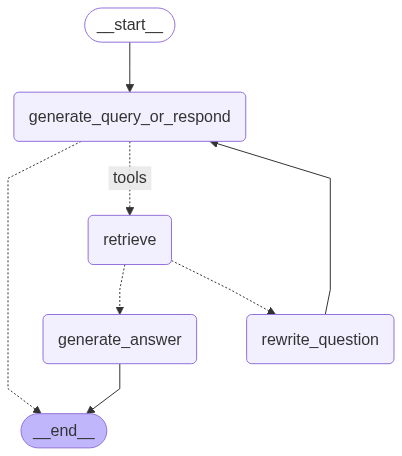

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))

## 9. Run the agentic RAG

In [21]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "How to calculate summary statistics in Db2?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        message = update["messages"][-1]
        print(f"Role: {message.type}")
        print(f"Content: {message.content}")
        print("\n\n")

decode: cannot decode batches with this context (calling encode() instead)
init: embeddings required but some input tokens were not marked as outputs -> overriding
llama_perf_context_print:        load time =      48.33 ms
llama_perf_context_print: prompt eval time =       5.24 ms /    12 tokens (    0.44 ms per token,  2288.33 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =       6.82 ms /    13 tokens
decode: cannot decode batches with this context (calling encode() instead)
init: embeddings required but some input tokens were not marked as outputs -> overriding
llama_perf_context_print:        load time =      48.33 ms
llama_perf_context_print: prompt eval time =      86.73 ms /     9 tokens (    9.64 ms per token,   103.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,     

Update from node generate_query_or_respond
Role: ai
Content: 



Update from node retrieve
Role: tool
Content: A.PURCHASE_AMOUNT * 100) AS MAPE FROM GOSALES.GOSALES_TEST AS A, GOSALES.GOSALES_TEST_PREDICTIONS AS B WHERE A.ID = B.ID
Dropping the Model
If I want to drop this model, I can use the DROP_MODEL SP:
CALL IDAX.DROP_MODEL('model=GOSALES.GOSALES_LINREG')
Conclusion
In this exercise, I built, evaluated, and deployed an end-to-end linear regression pipeline using 29 simple SQL queries — 17 of them are calls to SPs provided by Db2, and the remaining ones were SELECT statements. In this ML workflow, I didn’t need to bring any data outside of the database, nor did I need separate infrastructure for developing, training, and serving ML models. For many companies, machine learning in the database can be a cost effective and quicker path to embrace AI.
Related Resources
For creating an in-database ML pipeline using my above steps, you can download the GoSales dataset from this link and f

In [22]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "How to build a linear regression model with IBM Db2?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

decode: cannot decode batches with this context (calling encode() instead)
init: embeddings required but some input tokens were not marked as outputs -> overriding
llama_perf_context_print:        load time =      48.33 ms
llama_perf_context_print: prompt eval time =       7.08 ms /    15 tokens (    0.47 ms per token,  2117.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =       8.56 ms /    16 tokens
decode: cannot decode batches with this context (calling encode() instead)
init: embeddings required but some input tokens were not marked as outputs -> overriding
llama_perf_context_print:        load time =      48.33 ms
llama_perf_context_print: prompt eval time =       3.17 ms /     9 tokens (    0.35 ms per token,  2841.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,     

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (xX7wGT6eJ)
 Call ID: xX7wGT6eJ
  Args:
    query: How to build a linear regression model with IBM Db2?



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Despite being one of the earlier machine learning techniques, linear regression continues to be a top choice among ML practitioners for a regression task. For the past three years, over 80% of the respondents to Kaggle’s annual state of data science and machine learning survey mentioned linear regression as a ML algorithm they most frequently use. IBM Db2 provides an in-database stored procedure (SP) for Linear Regression as part of its ML library, which is a collection of over 200 SPs for performing different ML tasks in the database. Using the linear regression SP and other functionality of D